# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_4- XGBoost.ipynb* unicamente aplicando a **personas jurídicas**

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier

from xgboost import XGBClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(406267, 26)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [10]:
columnas = ['TIPOUSUARIO_PJ', 'FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM', 'USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING','USU_TIPO_NI','USU_TIPO_NoApl',
            'USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR', 'USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ',
            'USU_TAMANIO_SD','USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl', 'USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD',
            'USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl', 'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD',
            'USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO', 'USU_DEPART_DEN_POB','USU_DEPART_IDH','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [11]:
final_df.shape

(406267, 100)

In [12]:
pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)

0    98489
1     7009
Name: IND_CLIENTE, dtype: int64

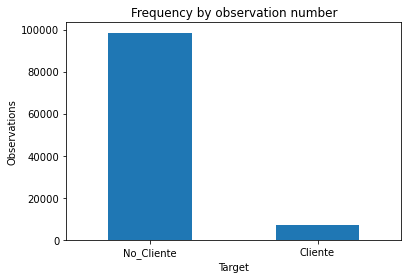

In [13]:
count_classes = pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [14]:
print('Los clientes suponen un % del total: ', ((7009/(len(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1])))*100))

Los clientes suponen un % del total:  2.3303598442658653


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 3% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [15]:
final_df_PJ = final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1]

In [16]:
features = final_df_PJ[columnas]
labels = final_df_PJ['IND_CLIENTE']

In [17]:
features.shape

(105498, 95)

In [18]:
labels.shape

(105498,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [19]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [20]:
train_x.shape

(73848, 95)

In [21]:
test_x.shape

(31650, 95)

In [22]:
train_y.shape

(73848,)

In [23]:
test_y.shape

(31650,)

--------------

--------------

#### 4.3 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [24]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [25]:
clf.fit(train_x, train_y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Observamos los resultados del modelo

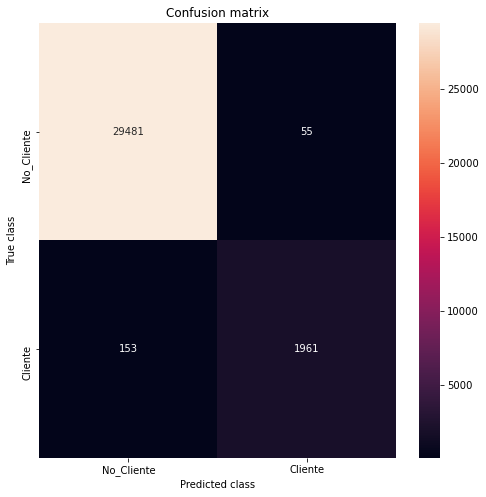

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.97      0.93      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.98      0.96      0.97     31650
weighted avg       0.99      0.99      0.99     31650



In [26]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [30]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [31]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,8.843495
1A_DESCGRUPOPROD_RES_PAGO,5.156056
TIPOEMAIL_TEMPORAL,4.309551
BONDAD_EMAIL,3.689777
CANAL_REGISTRO_4,3.010932
USU_TIPO_EMPRESARIO INDIVIDUAL,2.966421
USU_TIPO_NI,2.867246
IP_COUNTRY_PIB_NI,2.558399
1A_EMPCONSUL_EST_NI,2.471121
CANAL_REGISTRO_1,2.269356


In [32]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

------

------

#### 4.4 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.4.1 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [33]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 4895, 1: 4895})


In [34]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [35]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

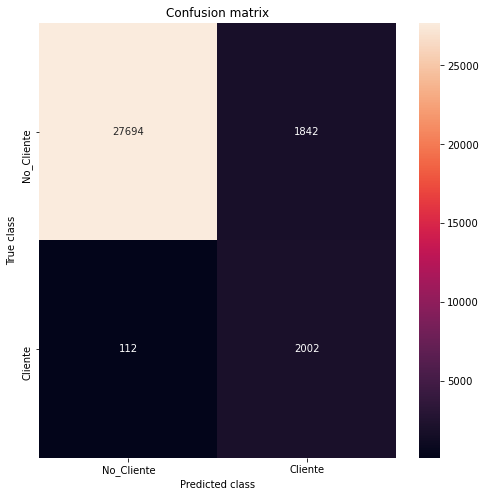

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29536
           1       0.52      0.95      0.67      2114

    accuracy                           0.94     31650
   macro avg       0.76      0.94      0.82     31650
weighted avg       0.96      0.94      0.95     31650



In [36]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [37]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [38]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,15.584089
BONDAD_EMAIL,3.984466
1A_DESCGRUPOPROD_PERF_PROMO,3.901761
1A_DESCGRUPOPROD_RES_PAGO,3.800205
IP_COUNTRY_PIB_Países de ingreso mediano bajo,3.540514
USU_ESTADO_SD,3.160745
TIPOEMAIL_TEMPORAL,2.589474
USU_TIPO_EMPRESARIO INDIVIDUAL,2.210239
USU_TAMANIO_SD,2.121827
CANAL_REGISTRO_4,2.044076


In [39]:
feature_importances[feature_importances['important'] > 0.01].shape

(24, 1)

------

##### **4.4.2 Oversampling en la clase minoritaria**

**SMOTE**

In [40]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [41]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution labels after resampling Counter({0: 68953, 1: 68953})


In [42]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [43]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

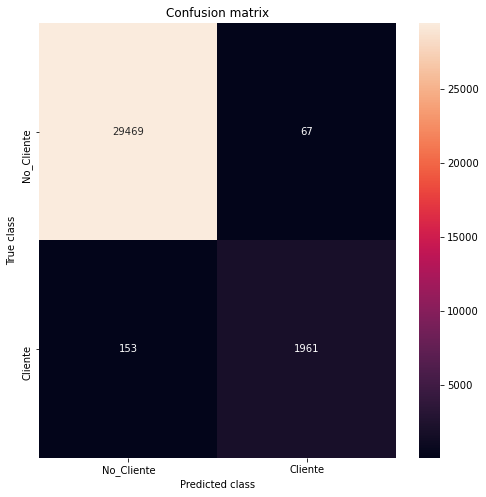

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.97      0.93      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.98      0.96      0.97     31650
weighted avg       0.99      0.99      0.99     31650



In [44]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [45]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [46]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_SD,11.148959
IP_COUNTRY_PIB_Países de ingreso mediano bajo,9.202162
FICH_PROMO_TOT,8.274719
TIPOEMAIL_TEMPORAL,6.696992
TIPOEMAIL_ADMINISTRACION,2.861535
USU_TIPO_EMPRESARIO INDIVIDUAL,2.622252
USU_TAMANIO_SD,2.529752
BONDAD_EMAIL,2.503955
1A_DESCGRUPOPROD_PERF_PROMO,2.404819
CANAL_REGISTRO_9,2.228061


In [47]:
feature_importances[feature_importances['important'] > 0.01].shape

(18, 1)

------

##### **4.4.3 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [48]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [49]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [50]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 41370, 1: 20685})


In [51]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [52]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

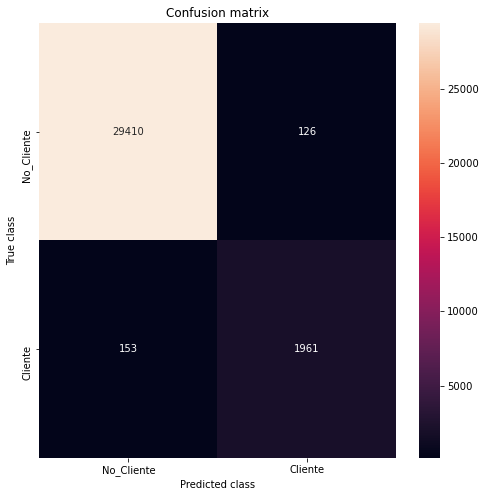

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.94      0.93      0.93      2114

    accuracy                           0.99     31650
   macro avg       0.97      0.96      0.96     31650
weighted avg       0.99      0.99      0.99     31650



In [53]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [54]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [55]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_SD,12.320482
FICH_PROMO_TOT,10.530705
USU_TIPO_EMPRESARIO INDIVIDUAL,3.215239
BONDAD_EMAIL,3.154088
1A_DESCGRUPOPROD_PERF_PROMO,3.104232
USU_TAMANIO_SD,2.723844
TIPOEMAIL_TEMPORAL,2.709685
1A_EMPCONSUL_EST_NI,2.512658
1A_EMPCONSUL_SECTOR_QUINARIO,1.912997
CANAL_REGISTRO_9,1.789530


In [56]:
feature_importances[feature_importances['important'] > 0.01].shape

(23, 1)

------

**SMOTETomek**

In [57]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [58]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 68946, 1: 68946})


In [59]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [60]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

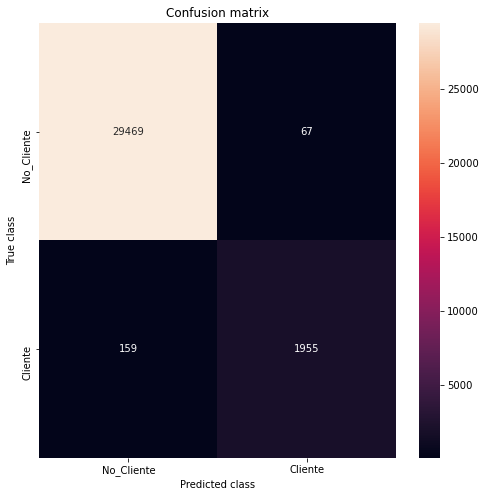

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.97      0.92      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.98      0.96      0.97     31650
weighted avg       0.99      0.99      0.99     31650



In [61]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [62]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [63]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_SD,15.372697
IP_COUNTRY_PIB_Países de ingreso mediano bajo,8.433568
FICH_PROMO_TOT,7.681289
TIPOEMAIL_TEMPORAL,5.795952
TIPOEMAIL_ADMINISTRACION,3.945050
USU_TIPO_EMPRESARIO INDIVIDUAL,2.458753
CANAL_REGISTRO_5,2.401967
1A_DESCGRUPOPROD_PERF_PROMO,2.310825
BONDAD_EMAIL,2.181086
CANAL_REGISTRO_9,1.853176


In [64]:
feature_importances[feature_importances['important'] > 0.01].shape

(19, 1)